In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val], verbose=False)
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20,
                             verbosity=0, random_state=123)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0,
                              random_state=123)

# Experiments on Toy Data

In [9]:
import numpy as np
prior = {'T': .1, 'S': .025, 'IPS': .025, 'DR': .25, 'R': .1, 'X': .25, 'DRX': .25}
np.sum([v for k,v in prior.items()])

1.0

In [6]:
import numpy as np
prior = {'T': .01/6, 'S': .01/6, 'IPS': .01/6, 'DR': .01/6, 'R': .01/6, 'X': .99, 'DRX': .01/6}
np.sum([v for k,v in prior.items()])

1.0

In [10]:
from aggregation import experiment, experiment_dr
import numpy as np

mses, cates, nuisance_metrics = experiment(1, n=10000, scale=1, random_state=123, reg=reg, clf=clf, prior_dict=prior, beta=100)

Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest


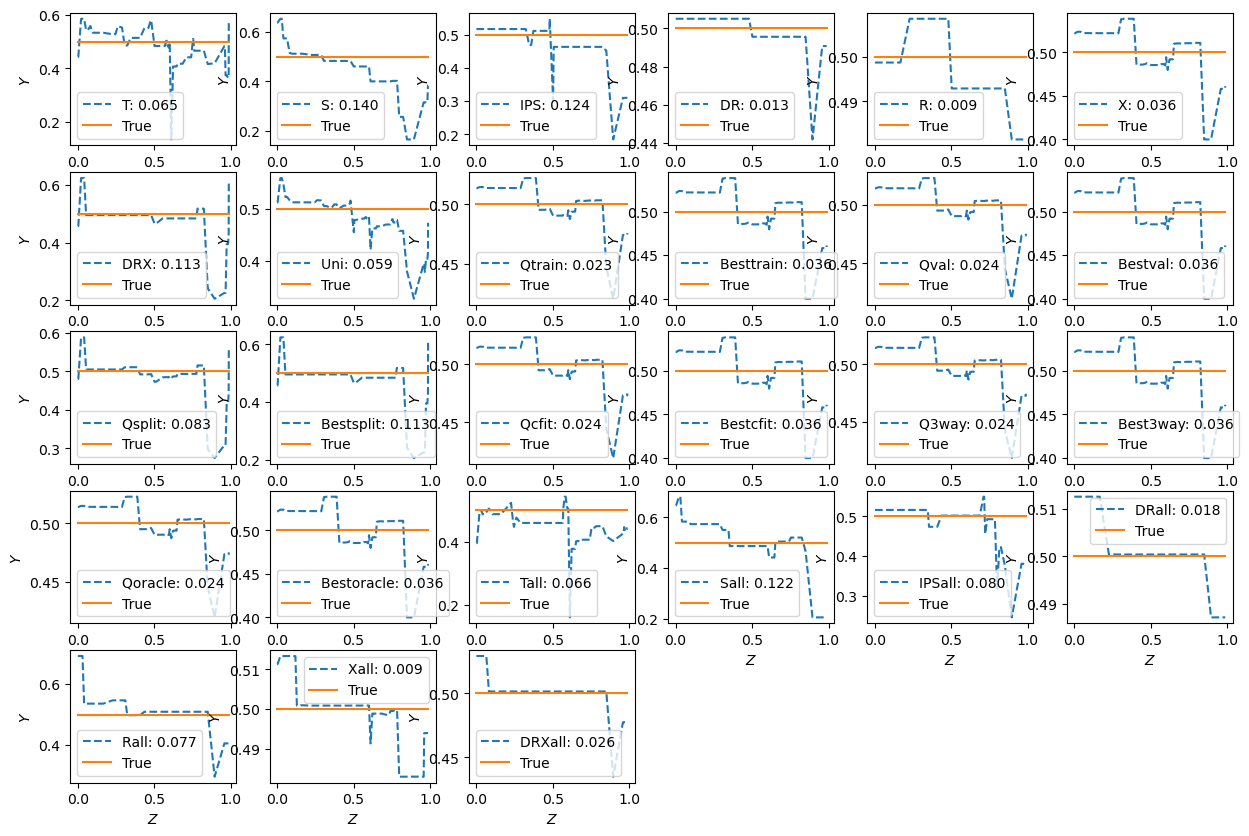

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(5, 6, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [11]:
from aggregation import experiment, experiment_dr
import numpy as np

mses, cates, nuisance_metrics = experiment_dr(1, n=5000, scale=.5, random_state=3, reg=reg, clf=clf)

3
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Evaluating all models on dtest


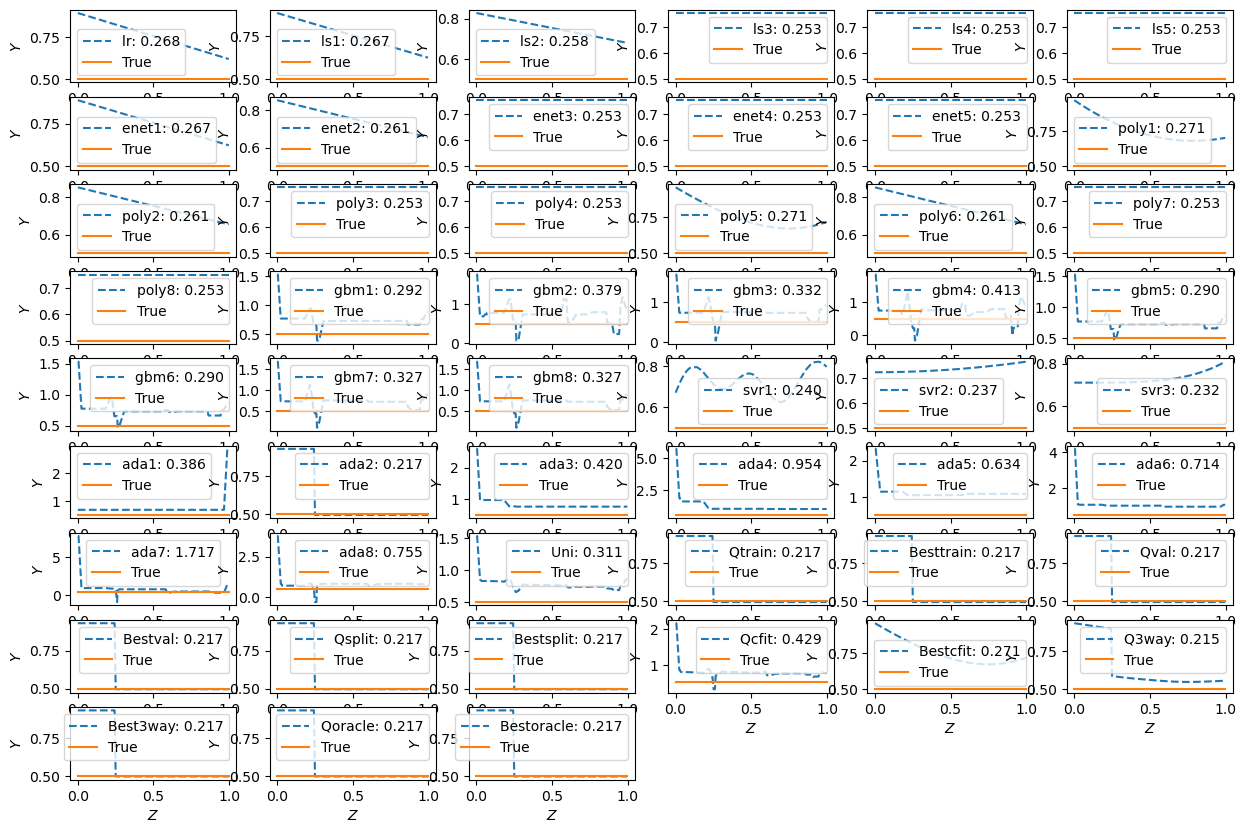

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(9, 6, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
from aggregation import experiment, experiment_dr
import numpy as np
import joblib
from joblib import Parallel, delayed 
import os

if not os.path.exists('results'):
    os.makedirs('results')

for scale in [.05, .2, .5]:
    for dgp in np.arange(3, 7):
        for n in [1000, 2000, 5000, 10000]:
            print(f'n={n}, DGP={dgp}')
            results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment_dr)(dgp, n=n, scale=scale,
                                                                            random_state=it, reg=reg, clf=clf)
                                                              for it in range(100))
            joblib.dump(results, os.path.join('results', f'results_dr_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

n=1000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:  5.2min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


n=2000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 11.4min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.8min finished


n=5000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 50.5min remaining:  2.7min


In [3]:
from aggregation import experiment, experiment_dr
import numpy as np
import joblib
from joblib import Parallel, delayed 
import os

if not os.path.exists('results'):
    os.makedirs('results')

for scale in [1, 2]:
    for dgp in np.arange(1, 7):
        for n in [5000, 10000]:
            print(f'n={n}, DGP={dgp}')
            results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n, scale=scale,
                                                                         random_state=it, reg=reg, clf=clf)
                                                              for it in range(100))
            joblib.dump(results, os.path.join('results', f'results_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

n=5000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=10000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


n=5000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=10000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


n=5000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


n=10000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


n=5000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.8s


Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting en

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=10000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


n=5000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


n=10000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


n=5000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


n=10000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.8s


Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dt

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


n=5000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=10000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


n=5000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=10000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.4s


Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracl

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


n=5000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracl

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=10000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


n=5000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=10000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


n=5000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on d

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s


Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on d

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=10000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


n=5000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=10000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting me

In [18]:
from aggregation import experiment, experiment_dr
import numpy as np
import joblib
from joblib import Parallel, delayed 
import os

if not os.path.exists('results'):
    os.makedirs('results')

prior = {'T': .16, 'S': .16, 'IPS': .04, 'DR': .16, 'R': .16, 'X': .16, 'DRX': .16}
print(np.sum([v for k,v in prior.items()]))
beta = 100

for dgp in np.arange(1, 7):
    for scale in [1, 2]:
        for n in [5000]:
            print(f'n={n}, DGP={dgp}')
            results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n, scale=scale,
                                                                         random_state=it, reg=reg, clf=clf, prior_dict=prior, beta=beta)
                                                              for it in range(100))
            joblib.dump(results, os.path.join('results', f'results_prior_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

1.0
n=5000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=5000, DGP=1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=5000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=5000, DGP=2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=5000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


n=5000, DGP=3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


n=5000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.3s


Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting en

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


n=5000, DGP=4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting en

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=5000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=5000, DGP=5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


n=5000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


n=5000, DGP=6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dt

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s


Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dt

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracle ensemble on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest
Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble split on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting oracl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
plt.figure(figsize=(15, 10))
it = 1
attr = 'median'
ylabel = 'Median RMSE Regret'
all_results = joblib.load('all_results.jbl')
for dgp in np.arange(1, 7):
    rmses_agg = {}
    for n in [500, 1000, 10000]:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
            rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                   'stderr': np.std(rmses) / np.sqrt(len(results)),
                                   'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                   '95': np.percentile(rmses, 95)}

    
    plt.subplot(2, 3, it)
    ngrid = [500, 1000, 10000]
    plt.plot(ngrid, [rmses_agg[n]['Qtrain'][attr] for n in ngrid], linewidth=5, label='Qtrain')
    for name in ['X', 'Uni', 'DRX', 'R', 'T', 'S', 'DR']:
        plt.plot(ngrid, [rmses_agg[n][name][attr] for n in ngrid], label=name)
    plt.title(f'DGP: {dgp}')
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(ylabel)
    it += 1
plt.tight_layout()
plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

#all_results = joblib.load('all_results.jbl')
rmses_agg = {}
for dgp in np.arange(4, 7):
    rmses_agg[f'DGP {dgp}'] = {}
    for n in [500, 1000, 10000]:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[f'DGP {dgp}'][n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
            rmses_agg[f'DGP {dgp}'][n][name] = f'{np.median(rmses):.2f} ({np.percentile(rmses, 95):.2f})'

    rmses_agg[f'DGP {dgp}'] = pd.DataFrame(rmses_agg[f'DGP {dgp}'])

table = pd.concat(rmses_agg, axis=1)

In [ ]:
table

In [ ]:
print(table.to_latex(multicolumn=True,bold_rows=True, multirow=True, column_format='r|ccc|ccc|ccc'))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

#all_results = joblib.load('all_results.jbl')
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg = {}
        rmses_all = {}
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results]))
            # clip top 1% failure modes
#             q1 = np.percentile(rmses, 99)
#             rmses = rmses[(rmses<q1)]
            rmses_all[name] = rmses
            rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                               'stderr': np.std(rmses) / np.sqrt(len(results)),
                               'median': np.median(rmses)}

        agg_means = pd.DataFrame(rmses_agg).T['mean'].values
        min_rmse = np.min(agg_means)
        min_ind = np.argmin(agg_means)
        min_name = names[min_ind]
        min_rmse_std = rmses_agg[min_name]['stderr']
        print(min_rmse, min_name, min_rmse_std)
        
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        rmses_all['oracle'] = oracle
        rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                               'stderr': np.std(oracle) / np.sqrt(len(results)),
                               'median': np.median(oracle)}

        plt.figure(figsize=(15, 7))
        it = 0
        for name, agg in rmses_agg.items():
            mean = agg['mean']
            if mean >= min_rmse + 20*min_rmse_std:
                continue
            plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                           showextrema=True, quantiles=[.05, .95])
            plt.scatter(name, mean)
            it += 1
        plt.title(f'DGP: {dgp} (n={n})')
        plt.xlabel('Method')
        plt.ylabel('RMSE')
        plt.xlim([-1, it])
        plt.show()
        display(pd.DataFrame(rmses_agg).T)

# Experiments on Semi-Synthetic Data

In [3]:
data = 'criteo' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = False # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 3 # max depth of random forest during for semi-synthetic model fitting
scale = .5 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [78]:
from aggregation import experiment

mses, cates, nuisances = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         random_state=1, reg=reg, clf=clf)

Fitting meta learners on dtrain
[0]	validation_0-rmse:9.13437
[1]	validation_0-rmse:8.68233
[2]	validation_0-rmse:8.25312
[3]	validation_0-rmse:7.84563
[4]	validation_0-rmse:7.45878
[5]	validation_0-rmse:7.09154
[6]	validation_0-rmse:6.74296
[7]	validation_0-rmse:6.41212
[8]	validation_0-rmse:6.09813
[9]	validation_0-rmse:5.80019
[10]	validation_0-rmse:5.51749
[11]	validation_0-rmse:5.24930
[12]	validation_0-rmse:4.99491
[13]	validation_0-rmse:4.75364
[14]	validation_0-rmse:4.52487
[15]	validation_0-rmse:4.30798
[16]	validation_0-rmse:4.10239
[17]	validation_0-rmse:3.90758
[18]	validation_0-rmse:3.72301
[19]	validation_0-rmse:3.54820
[20]	validation_0-rmse:3.38269
[21]	validation_0-rmse:3.22602
[22]	validation_0-rmse:3.07779
[23]	validation_0-rmse:2.93759
[24]	validation_0-rmse:2.80505
[25]	validation_0-rmse:2.67981
[26]	validation_0-rmse:2.56153
[27]	validation_0-rmse:2.44987
[28]	validation_0-rmse:2.34454
[29]	validation_0-rmse:2.24523
[30]	validation_0-rmse:2.15168
[31]	validation_0

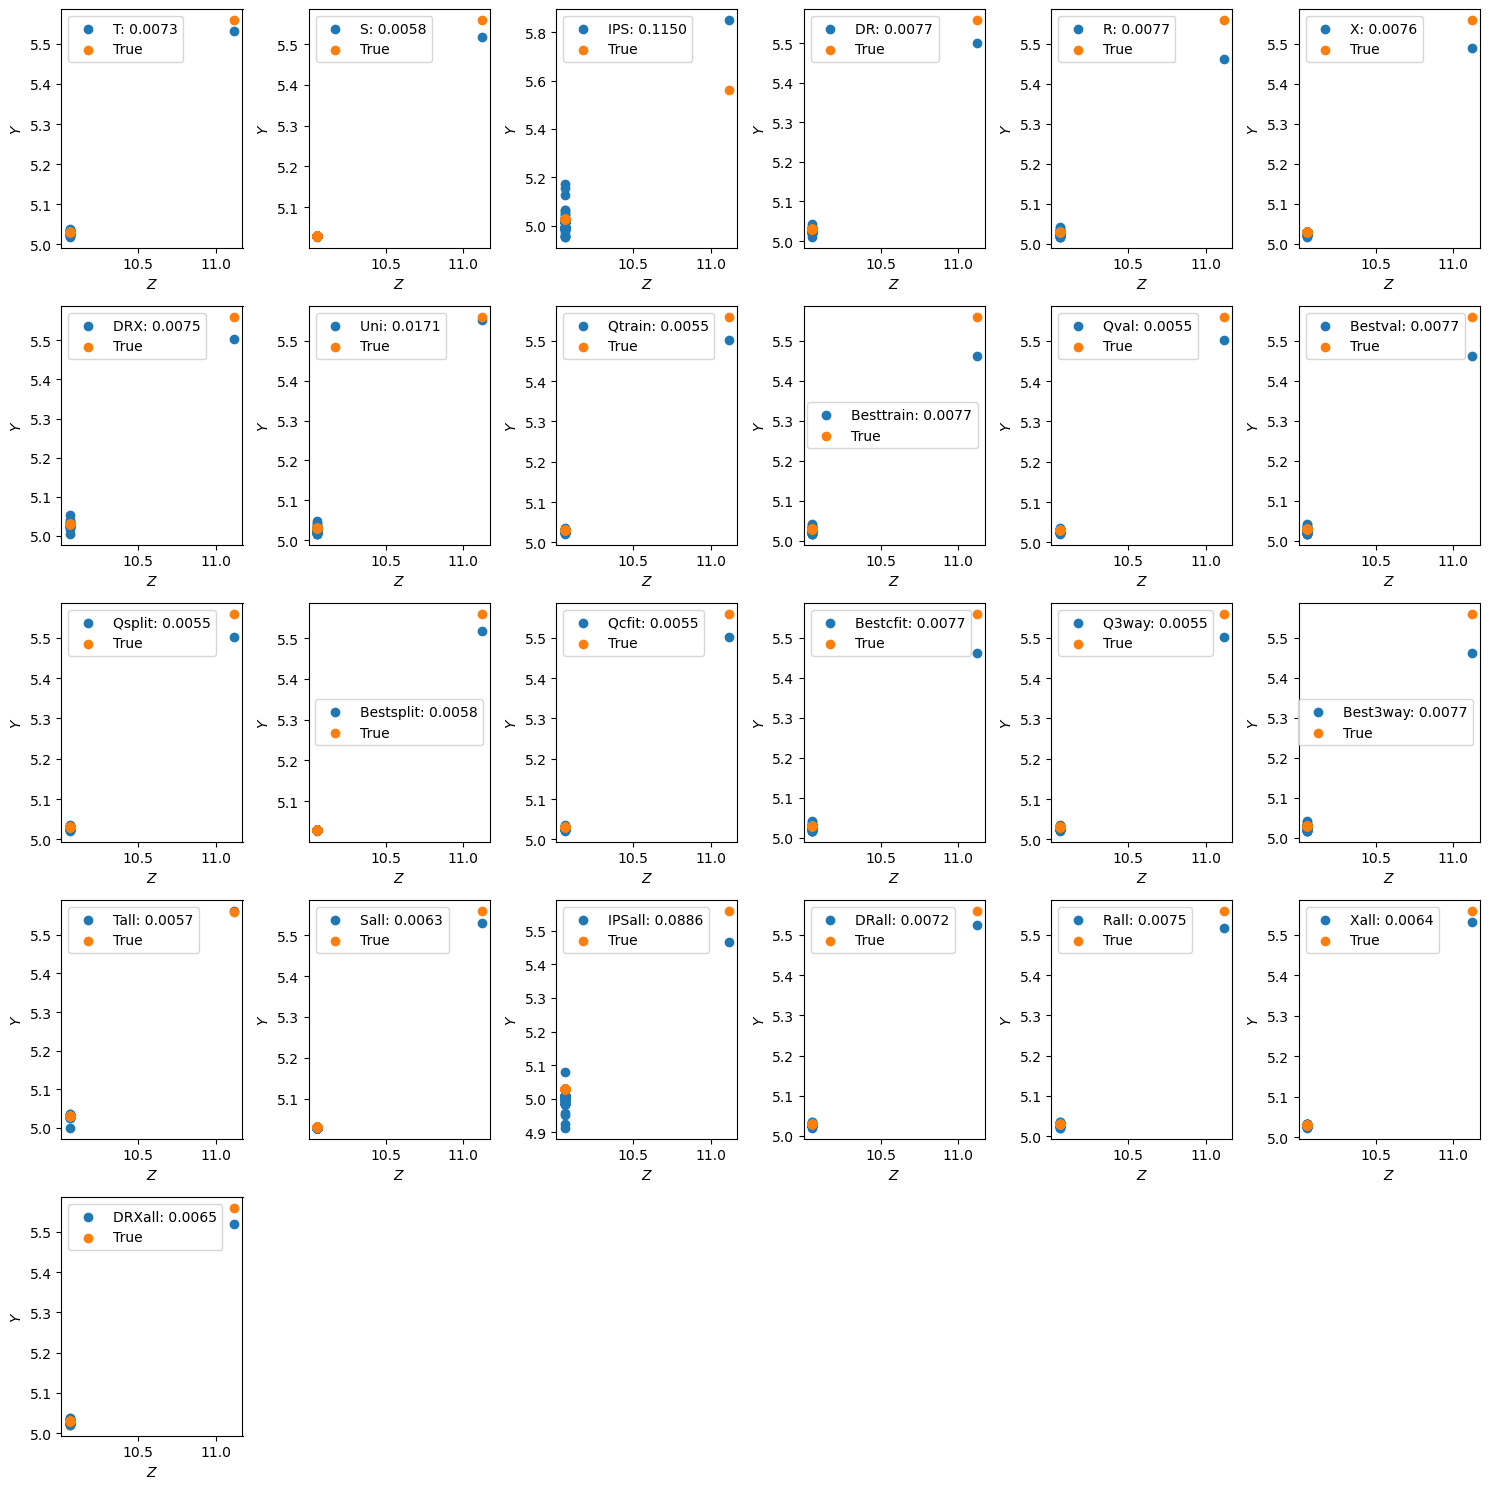

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(5, 6, it + 1)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from joblib import Parallel, delayed
from aggregation import experiment

results = Parallel(n_jobs=-1, verbose=11)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             reg=reg, clf=clf,
                                                             ensemble_methods=['train'],
                                                             random_state=it)
                                                  for it in range(16))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
import pandas as pd 
import numpy as np

mses, _, _ = results[0]
names = list(mses.keys())

oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                          if ((not name.startswith('Q')) and (not name.startswith('Best'))
                              and (not name.startswith('Uni')) and (not name.endswith('all')))]),
                axis=0)

rmses_agg = {}
rmses_all = {}
for name in names:
    rmses = np.sqrt(np.array([r[0][name] for r in results]))
    # clip top 1% failure modes
    rmses_all[name] = rmses - oracle
    rmses_agg[name] = {'mean': np.mean(rmses_all[name]), 'std': np.std(rmses_all[name]),
                       'stderr': np.std(rmses_all[name]) / np.sqrt(len(results)),
                       'median': np.median(rmses_all[name])}


# rmses_all['oracle'] = oracle
# rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
#                        'stderr': np.std(oracle) / np.sqrt(len(results)),
#                        'median': np.median(oracle)}
    
agg_means = pd.DataFrame(rmses_agg).T['mean'].values
min_rmse = np.min(agg_means)
min_ind = np.argmin(agg_means)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name]['stderr']
print(min_rmse, min_name, min_rmse_std)

plt.figure(figsize=(15,10))
it = 0
for name, agg in rmses_agg.items():
    if name.endswith('split') or name.endswith('3way'):
        continue
    mean = agg['mean']
    if mean >= min_rmse + 100*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                   showextrema=True, quantiles=[.1, .9])
    plt.scatter(name, mean)
    it += 1
plt.axhline(0)
plt.title(f'DGP: {dgp} (n={n})')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()

In [ ]:
display(pd.DataFrame(rmses_agg).T)

In [ ]:
import seaborn as sns
df = pd.DataFrame(rmses_agg)
df = df.drop([c for c in df.columns if c.endswith('3way') or c.endswith('split') or c.startswith('IPS')], axis=1)
plt.figure(figsize=(15,10))
sns.barplot(df.loc[['median']])
plt.show()